# Index

# 1. Libraries setup

### Import the fastai library

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Import various functionality libraries

In [3]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from PIL import Image # Python Image Library, get sizes from images
from collections import Counter # Class for counting purposes
from math import exp
from tqdm import tqdm

### Import keras

In [4]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Using TensorFlow backend.


<br>
<br>
# 2. Environment setup

### Environment

The environment overview

```
./input
│   train.csv    
│
└─── train
│   │   train_whale1.jpg
│   │   train_whale2.jpg
│
│
└─── test
│   │   test_whale1.jpg
│   │   test_whale2.jpg
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Initialize the environment variables

In [5]:
INPUT_PATH = ".\\input"
TRAIN_PATH = f'{INPUT_PATH}\\train'
DOWNLOAD_PATH = "C:\\Users\\David\\.kaggle\\competitions\\dogs-vs-cats-redux-kernels-edition"

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api <br>
Remember to accept the rules of the competition, otherwise it won't work.

In [6]:
if (os.system("kaggle competitions download -c dogs-vs-cats-redux-kernels-edition") == 0): print("Compressed files ready")

Compressed files ready


### Create the input directory

In [7]:
if not os.path.exists(f'{INPUT_PATH}'):
    os.mkdir(f'{INPUT_PATH}')

### Extract the data to the input directory

Check the download directory

In [8]:
os.listdir(DOWNLOAD_PATH)

['sample_submission.csv', 'test.zip', 'train.zip']

Extract the data

In [9]:
if "train" not in os.listdir(INPUT_PATH):
    print("Extracting the training set...")
    train_zip = zipfile.ZipFile(DOWNLOAD_PATH+"\\train.zip", mode="r")
    train_zip.extractall(INPUT_PATH)
    train_zip.close()
    
if "test" not in os.listdir(INPUT_PATH):
    print("Extracting the test set...")
    test_zip = zipfile.ZipFile(DOWNLOAD_PATH+"\\test.zip", mode="r")
    test_zip.extractall(INPUT_PATH)
    test_zip.close()

print("All files ready")

All files ready


### Create the submission directory

In [10]:
if not os.path.exists(INPUT_PATH+"\\submission"): 
    os.mkdir(INPUT_PATH + "\\submission")
print("Submmission directory ready")

Submmission directory ready


### Check everything is correct

In [11]:
expected_dir = ['submission','train',  'test']
current_dir = os.listdir(INPUT_PATH)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['models', 'submission', 'test', 'tmp', 'train', 'train.csv']
Everything is correct


<br>
<br>
# 3. Data exploration

<br>
## 3.1 Training dataframe

### Training dataframe creation

Generate the pandas dataframe that will link each image to the corresponding category.<br>
The category is determined by the prefix of the image.

In [12]:
images_filenames = os.listdir(TRAIN_PATH)
images_classes = [image_filename[0:3] for image_filename in images_filenames]

In [13]:
train_df = pd.DataFrame({"Filename" : images_filenames, "Category" : images_classes})
train_df = train_df[["Filename", "Category"]]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
Filename    25000 non-null object
Category    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB


### Training dataframe structure


As we can see we have two columns, corresponding to the image filename path and the class, either a dog or a cat.

In [14]:
train_df.head()

,Filename,Category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [15]:
train_df.to_csv(path_or_buf=f'{INPUT_PATH}\\train.csv', index=False)

<br>
## 3.2 Labeled dataset data analysis

### Number of training examples and categories

In [16]:
n_train_images = train_df["Filename"].count()
categories = train_df["Category"].unique()
n_categories = len(train_df["Category"].unique())
ratio_images_per_category = round(n_train_images / n_categories, 2)
print(f"Number of training images: {n_train_images}")
print(f"Number of categories: {n_categories}")
print(f"Average images per category: {ratio_images_per_category}")

Number of training images: 25000
Number of categories: 2
Average images per category: 12500.0


Quite a lot of images and perfectly balanced

<br>
### Sizes of the images

Let's plot the most common sizes of the training set

In [17]:
# Create a counter object with the sizes of the training set images
img_sizes_freqs = Counter([Image.open(f'{TRAIN_PATH}//{i}').size for i in train_df['Filename']])
# Extract the 10 most common sizes
most_common_sizes = img_sizes_freqs.most_common(20)

Plot a histogram to visualize it better.

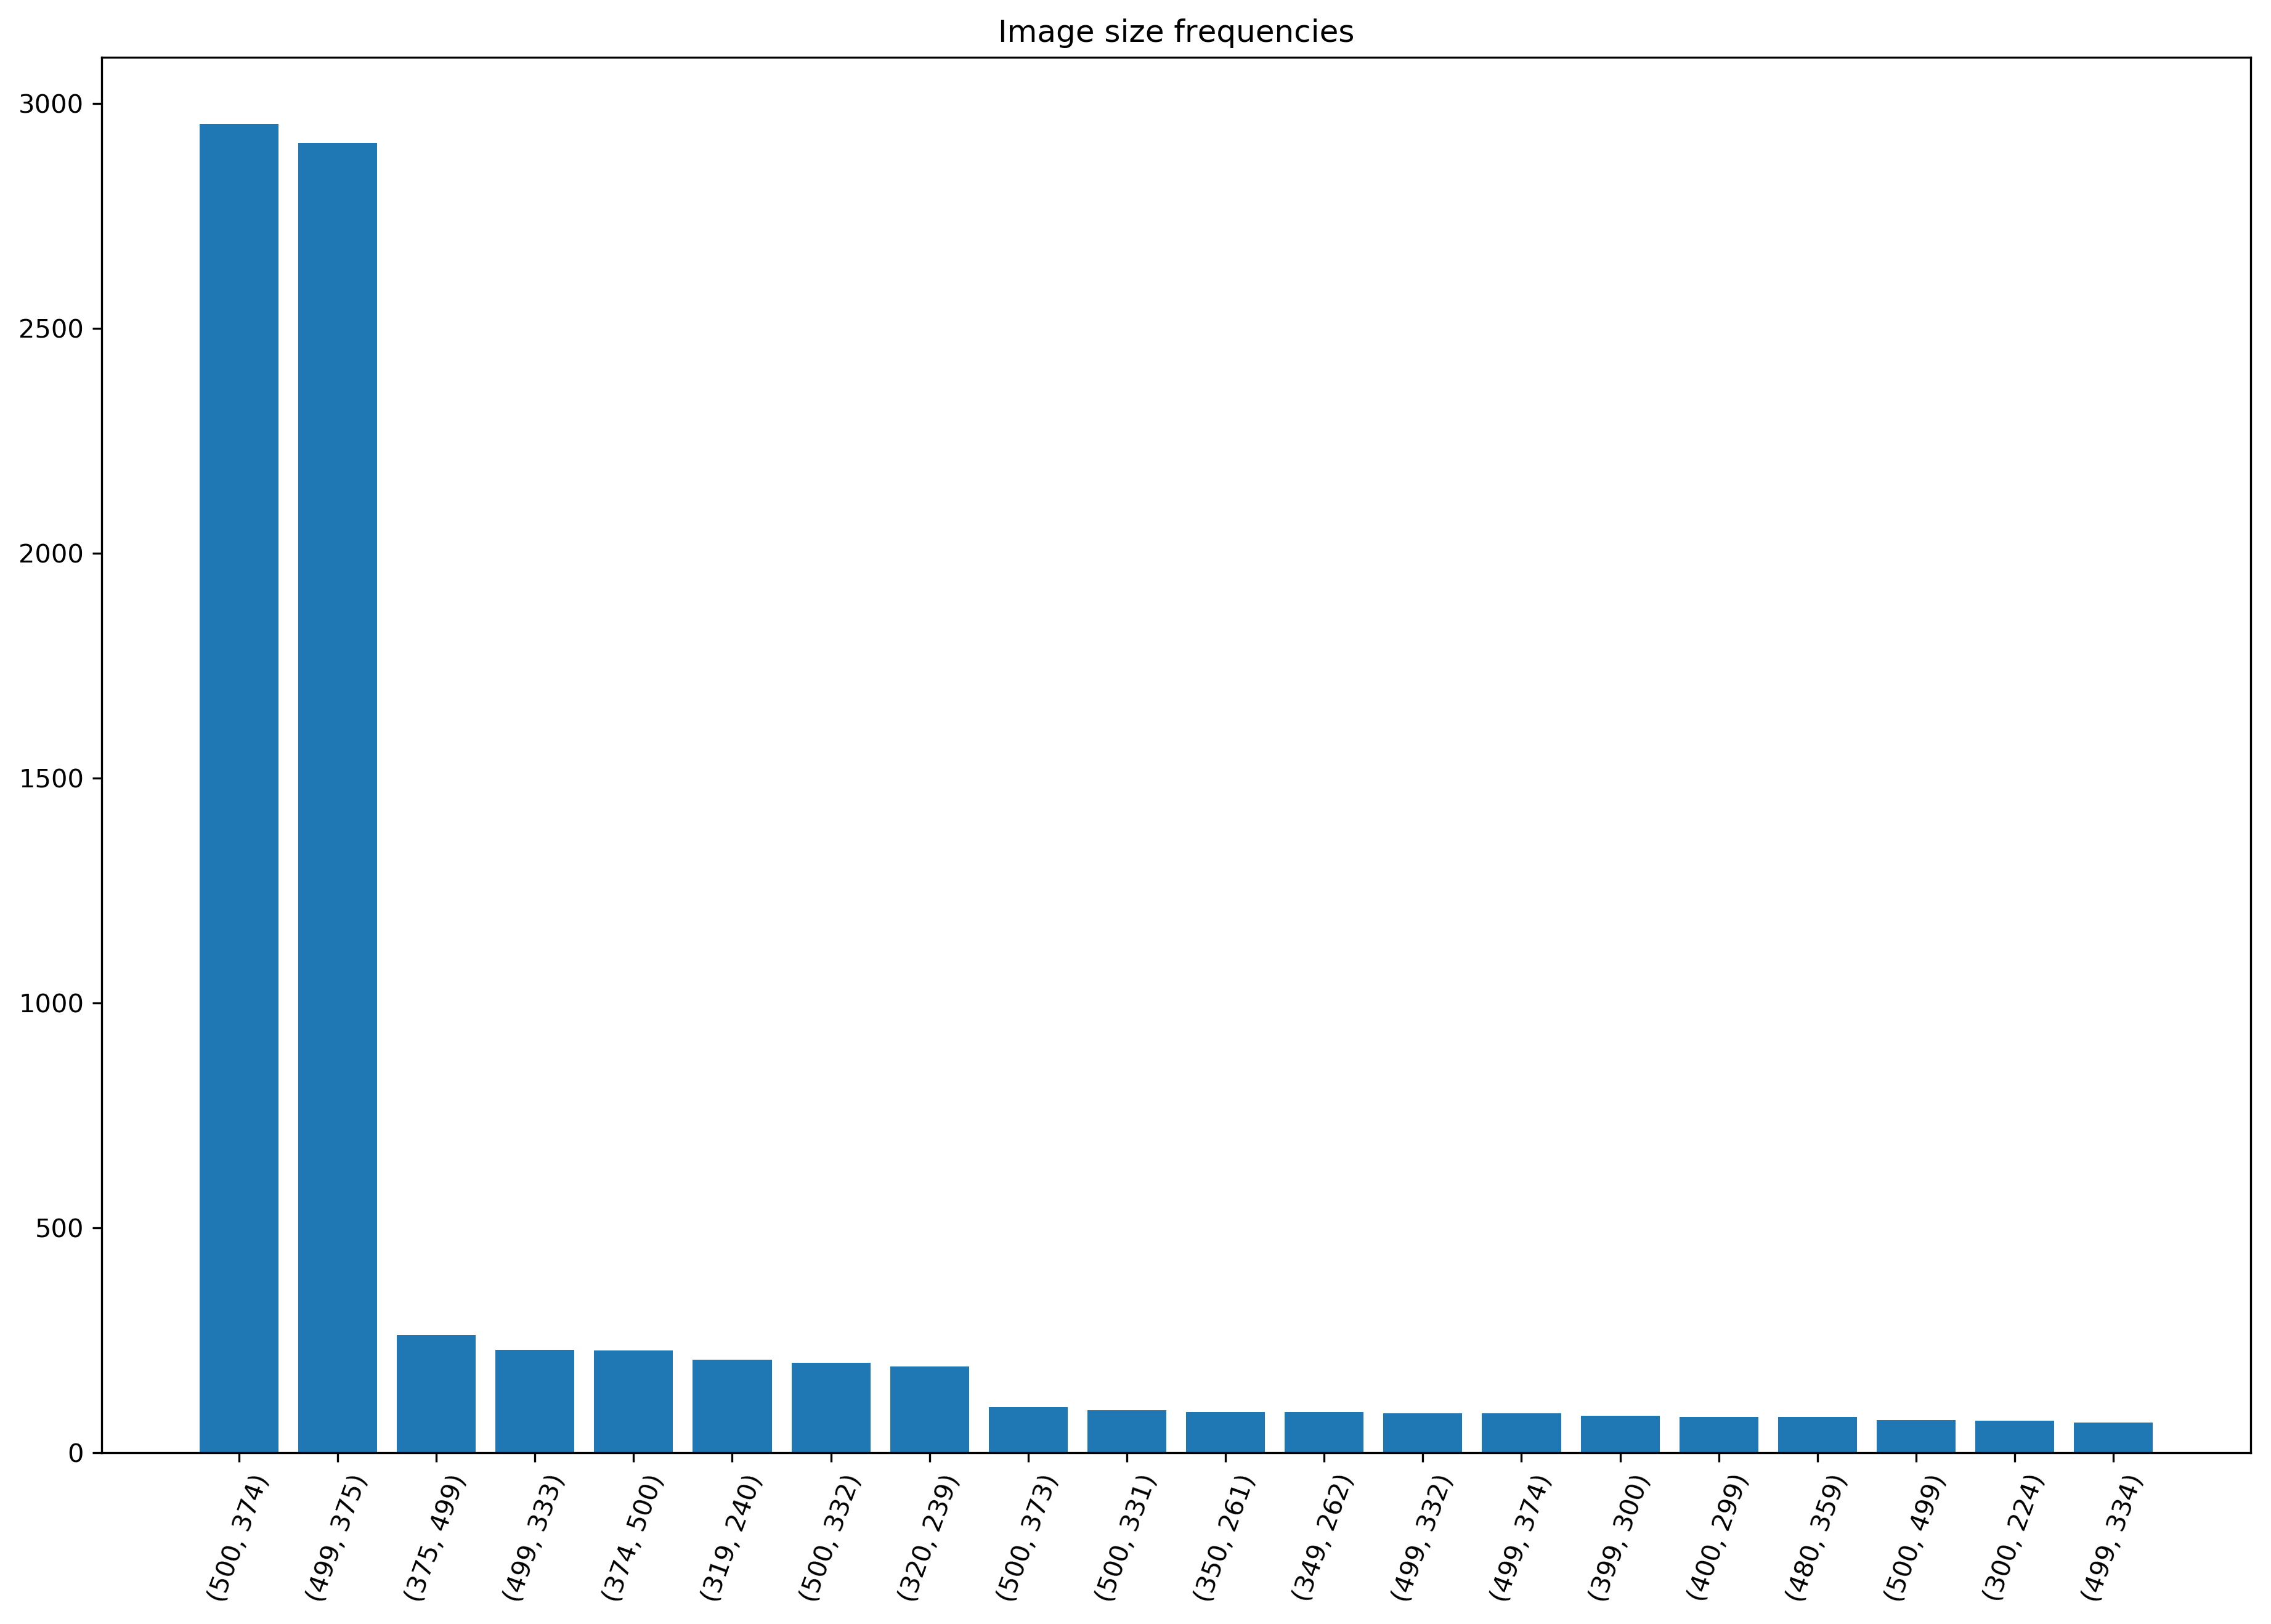

In [18]:
sizes = [img_size_freq[0] for img_size_freq in most_common_sizes]
freqs = [img_size_freq[1] for img_size_freq in most_common_sizes]
plt.figure(figsize=(15,10), dpi=300)
plt.bar(range(len(freqs)), freqs, align="center")
plt.xticks(range(len(sizes)), sizes, rotation = 70)
plt.title("Image size frequencies")
plt.show()

Sizes don't vary that much and are grouped in mostly 2 categories.

<br>
## 3.3 Training data visualization

### Welcoming pet

Load a random image to welcome us.

In [19]:
def get_random_image_path():
    random_image = train_df.sample(1)["Filename"].values[0]
    random_image_path = f'{TRAIN_PATH}\\{random_image}'
    return random_image_path

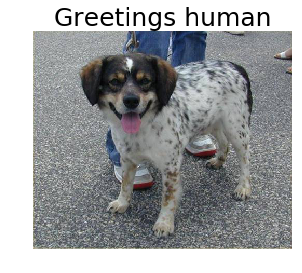

In [20]:
welcoming_pet =  plt.imread(get_random_image_path())
image_plot = plt.imshow(welcoming_pet)
plt.axis("Off")
title = plt.title("Greetings human", fontsize=25)

<br>
### Training set images visualization

Create a function to retrieve n random images from the dataset.

In [21]:
def get_random_labeled_images(n):
    """Returns iterable of n lists of random whale images and whale id pairs from the training dataset
        [img_name1, img1], [img_name2, img2], ..., [img_name3, img3]
    """
    train_sample = train_df.sample(n)
    categories = [category for category in train_sample["Category"]]
    images = [plt.imread(f'{TRAIN_PATH}\\{image_filename}')  for image_filename in train_sample["Filename"]]
    labeled_images = zip(categories, images)
    return labeled_images

<br>
Create a function to display n whales with the corresponding identifier.

In [22]:
def plot_random_labeled_images(n):
    """Plots n random images with the corresponding identifier
    """
    labeled_images = get_random_labeled_images(n)
    columns = 5
    rows = (n // columns) + 1
    width, height = columns * 3, rows * 3
    figure = plt.figure(figsize=(width,height))
    for i, labeled_image in enumerate(labeled_images):
        subplot = figure.add_subplot(rows,columns,i+1)
        subplot.axis("Off")
        plt.title(labeled_image[0])
        plt.imshow(labeled_image[1])

<br>
<a id="display_whales"> </a>
Let's see some puppies


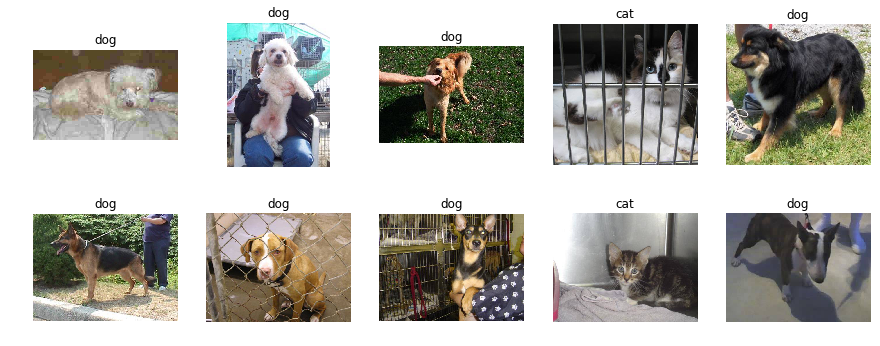

In [23]:
plot_random_labeled_images(10)

<br>
<br>
# 4. Model training

Building a successful neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also, we shouldn't make decisions based on "gut feelings" or "divine visions".

<br>
## 4.1 First iteration: Basic Model

My first priority is to build a basic and dirty classifier that will output something.
That something doesn't have to be great, it can be just above garbage, but that's more than enough to extract some metrics that will drive our decisions much better.
For that reason, I won't bother for augmentations, tricky algorithms or anything more than the very basics at this point. I will just focus on predicting something I can upload to kaggle.

### Architecture
The chosen architecture is resnet34, it comes pretrained with a huge imagenet dataset and it's not too complex.

In [24]:
arch = resnet34

### Transformations size
Resnet34 was trained on mostly 224·224 to 300·300 images sizes. For that reason, transforming the training images to that size should result in decent result.

In [25]:
tfms = tfms_from_model(arch, 224)

### Validation set

As explained earlier, because we have so many categories with only one example, using a validation set will probably result in a training set that doesn't include all categories.
Therefore, the trained network won't have the right output dimension, thus our predictions won't be of any use.
So what can we do in this situation? We will train the network in 2 steps:
<ol>
<li> We will use a standard 20% of the dataset as a validation set to find a good learning rate.
<li> We will train the network with that learning rate on the whole dataset. 
</ol>

In [26]:
step = 1
if step == 1:
    val_idxs = get_cv_idxs(n_train_images, val_pct=0.2)
# The fastai library requires at least one image for the validation set. A new whale image is used
elif step == 2:
    new_whale_index = train_df.loc[train_df.Id =="new_whale", "Image"].index[0]
    val_idxs = np.array([cal_idxs])

### Data transformation
Now we can adapt the training set images to train a neural net based on the previous options.<br>
We don't have folders for each category so we will create the data from the csv file.

In [27]:
data = ImageClassifierData.from_csv(path=INPUT_PATH, csv_fname=f'{INPUT_PATH}\\train.csv',folder="train", tfms=tfms, test_name="test")

### Learning rate
Create a pretrained convolutional neural network instance. 

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Compute the learning rate related info

In [29]:
learn.lr_find()

 86%|████████▌ | 269/313 [00:03<00:00, 79.93it/s, loss=0.482]


Our learning instance has a scheduler that exponentially increases the learning rate with each batch.<br>
Let's plot how this scheduler increases the learning rate with each iteration.

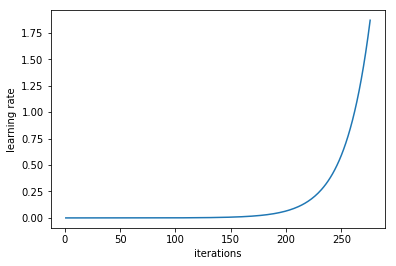

In [30]:
learn.sched.plot_lr()

Check how the loss decreases faster for a bigger learning rate until it becomes unstable.

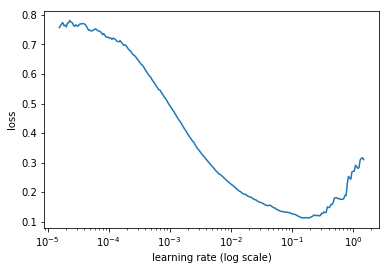

In [31]:
learn.sched.plot()

A learning rate of 0.1 seems like a reasonable choice.

### Training
Train the model with the chosen learning rate for 2 epochs or cycles.

In [32]:

learn.fit(lrs=0.01, n_cycle=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.052368   0.031213   0.9886    
    1      0.040952   0.029853   0.9896                        



[0.02985333309471607, 0.9896]

<br>
<br>
# 5. Model validation

### 5.1 Understanding the output

We should be worried about the chosen activation function for our last layer, as it's nature is going to greatly define the neural network.<br>
Let's check out what the last layer activation function is.

In [33]:
learn[-1]

LogSoftmax()

The last layer outputs the logarithm of the softmax function of the activations of the previous layer (read that again).

In this case, the softmax function presents the following properties:
   - The sum of all the values of the output is equal to 1
   - It tends to "choose" only one category over the others exponentially

Now let's think about our current dataset. This neural network has to predict if the animal is either a dog or a cat.
So we could see our prediction as a mutual exclusion problem where it only makes sense to predict one kind of animal.
This goes well with the properties of the softmax function, so it seems like a reasonable choice to use as the last layer.


#### Logarithm of the softmax function

$$L_i = \log\left(\frac{e^{i}}{ \sum_j e^{j} }\right)$$
The output of the softmax function ranges from 0 to 1:<br>
 - 0 corresponds to a very unlikely match<br>
 - 1 corresponds to an almost certain match

The output of the logarithm of the softmax function ranges from -inf to 0:<br>
 - -inf corresponds to a very unlikely match<br>
 - 0 corresponds to an almost certain match


### 5.2 Making the predictions

Important reminder. All the prediction related data of our neural network is contained in the data object we created in the model training.<br>
<ul>
    <li>To obtain the ordered classes we use the <b>data.classes</b> attribute.
    <li>To obtain the ordered validation images we use the <b>data.val_ds.fnames</b> attribute.
</ul>

In [63]:
data.val_ds.denorm(data.val_ds[42][0])

array([[[[ 0.50833,  0.38834,  0.17429],
         [ 0.483  ,  0.37888,  0.21458],
         [ 0.47533,  0.37947,  0.22395],
         ..., 
         [ 0.36578,  0.28893,  0.15743],
         [ 0.3481 ,  0.26066,  0.15197],
         [ 0.33038,  0.23359,  0.1427 ]],

        [[ 0.4951 ,  0.39563,  0.18733],
         [ 0.48972,  0.39785,  0.22573],
         [ 0.48704,  0.39847,  0.23606],
         ..., 
         [ 0.33858,  0.2742 ,  0.15196],
         [ 0.30486,  0.23512,  0.13392],
         [ 0.24198,  0.16152,  0.07681]],

        [[ 0.47482,  0.40301,  0.20981],
         [ 0.47842,  0.40222,  0.22808],
         [ 0.47756,  0.40148,  0.22862],
         ..., 
         [ 0.23927,  0.19553,  0.08553],
         [ 0.30367,  0.25468,  0.16689],
         [ 0.2391 ,  0.18405,  0.1138 ]],

        ..., 
        [[ 0.16581,  0.10648,  0.07266],
         [ 0.14429,  0.11125,  0.05542],
         [ 0.14184,  0.11602,  0.05328],
         ..., 
         [ 0.09412,  0.07059,  0.02353],
         [ 0.09412

We set the is_test flag to False to tell the model to predict on the validation set.<br>
We compute the exponential of the output to get the probabilities in the 0 to 1 range.

In [210]:
val_log_predictions = learn.predict(is_test=False)
val_probabilities = np.exp(val_log_predictions)
val_predictions = np.argmax(val_log_predictions, axis=1) # The index of the max value directly maps the category (0 -> cat, 1 -> dog)

## Analyzing

First we will create some functions to plot the results

Random by mask gets n random indexes of the validation predictions are True in the mask array.<br>
np.where(mask) returns the indexes where the mask element is True: [True, False, True] --> [0,2]<br>
It doesn't replace the chosen images to avoid duplicates.

In [211]:
def rand_by_mask(mask_array): return np.random.choice(np.where(mask_array)[0], 4, replace=False)

Random by correct returns n random indexes of the predictions that are either correct or incorrect depending on is_correct.<br>
It supplies the mask array to rand_by_mask which then selects the images indexes.

In [212]:
def rand_by_correct(is_correct): return rand_by_mask((val_predictions == data.val_y) == is_correct)

In [213]:
np.where((val_predictions == data.val_y) == False)

(array([ 186,  187,  277,  306,  363,  501,  578,  652,  886,  946,  954, 1104, 1140, 1153, 1267, 1341, 1410,
        1476, 1480, 1482, 1498, 1709, 1807, 1873, 2165, 2325, 2377, 2430, 2560, 2579, 2626, 3147, 3242, 3257,
        3357, 3460, 3508, 3778, 3857, 3940, 4056, 4170, 4295, 4505, 4532, 4607, 4611, 4633, 4653, 4667, 4720,
        4909], dtype=int64),)

Plot image with title selects the images and the probabilites of the validation set by the indexes provided.<br>

In [272]:
def plot_image_with_title(idxs, title, y):
    imgs = [plt.imread(f"{INPUT_PATH}\\{data.val_ds.fnames[i]}") for i in idxs] # Select the images filenames and create a list of the loaded images
    titles_probs = [val_probabilities[i][y] for i in idxs] # Select the y category probability for each image
    print(title)
    return plots(imgs, rows=1, titles=titles_probs)

In [215]:
def plots(imgs, figsize=(12,6), rows=1, titles=None):
    figure = plt.figure(figsize=figsize)
    columns = len(imgs)//rows
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, columns, i+1)
        subplot.axis("Off")
        if titles is not None: subplot.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i])

Correctly classified


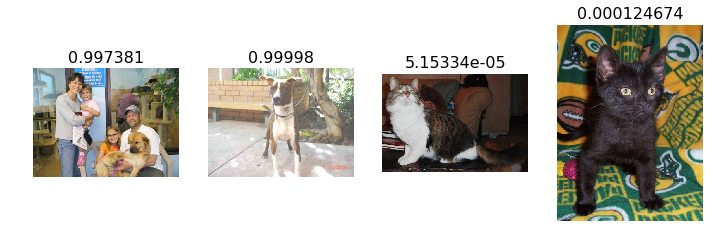

In [303]:
plot_image_with_title(rand_by_correct(True), "Correctly classified",1)

Incorrectly classified


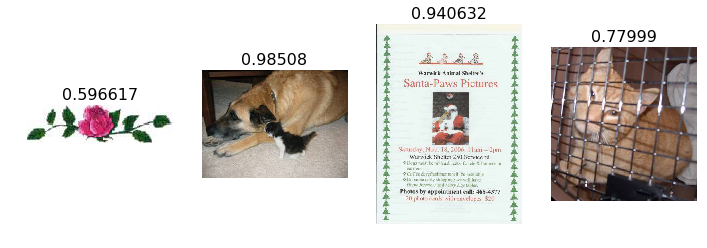

In [126]:
plot_image_with_title(rand_by_correct(False), "Incorrectly classified")

## Most correct, incorrect and uncertain

Most by mask gets a mask of the correctly or incorrectly classified class and sorts the indexes to extract the most correct, incorrect or uncertain images.<br>
Because we are using the dogs probabilities to compute

In [262]:
val_probabilities[:,0]

array([ 0.99773,  0.99439,  0.99996, ...,  0.00012,  0.00005,  0.00212], dtype=float32)

In [278]:
val_probabilities[347,0]

0.50000173

In [263]:
val_predictions

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [251]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [316]:
def most_by_mask(mask, y):
    indexes = np.where(mask)[0]
    print(val_probabilities[:,y][indexes])
    result = indexes[np.argsort(val_probabilities[:,y][indexes])[:4]]
    print(result)
    return result

In [317]:
def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    result = most_by_mask(((val_predictions == data.val_y)==is_correct) & (data.val_y == y), y)
    return result

[ 0.99773  0.99439  0.99996 ...,  0.99866  0.99988  0.99992]
[ 347  952 2427 1516]
Most correct cats


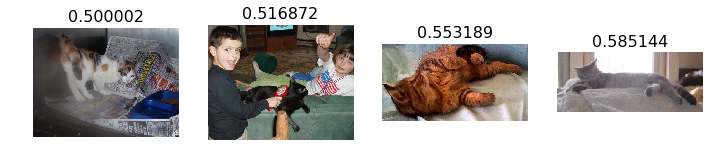

In [318]:
plot_image_with_title(most_by_correct(0, True), "Most correct cats", 0)

[ 0.99984  0.99986  0.99989 ...,  0.99988  0.99995  0.99788]
[3649 2817 3134 2980]
Most correct dogs


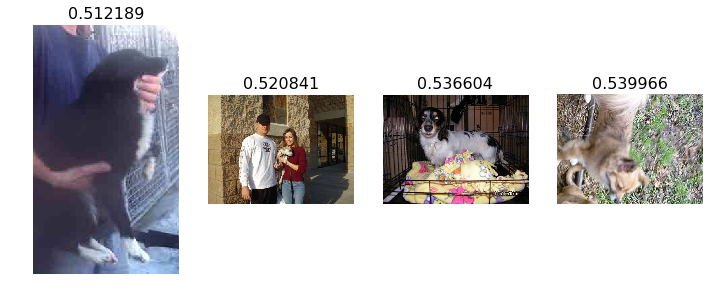

In [319]:
plot_image_with_title(most_by_correct(1, True), "Most correct dogs", 1)

[ 0.01972  0.10979  0.22001  0.00606  0.15994  0.05937  0.28138  0.2021   0.31511  0.45433  0.49207  0.16647
  0.27183  0.04107  0.25271  0.18296  0.27791  0.07801  0.06959  0.03554  0.16852  0.0829   0.36478  0.30852
  0.38466  0.40338  0.01492  0.18749]
[ 306 2377  186 1482]
Most incorrect cats


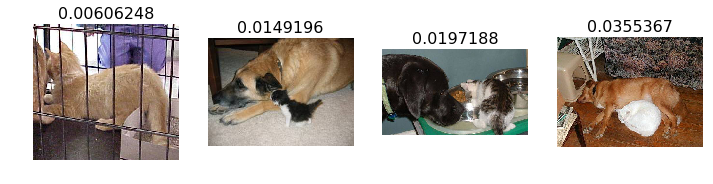

In [320]:
plot_image_with_title(most_by_correct(0, False), "Most incorrect cats", 0)

[ 0.14162  0.21352  0.01081  0.00067  0.332    0.32768  0.48794  0.3731   0.08396  0.10718  0.05325  0.08026
  0.41518  0.08518  0.35297  0.43617  0.30382  0.48754  0.01655  0.26352  0.01901  0.10855  0.20731  0.14114]
[3147 2626 4611 4653]
Most incorrect cats


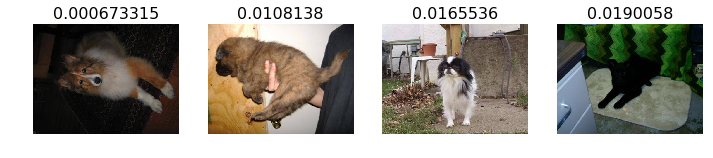

In [321]:
plot_image_with_title(most_by_correct(1, False), "Most incorrect cats", 1)

<br>
<br>
# 5. Model predictions

### 5.2 Making the predictions

Important reminder. All the prediction related data of our neural network is contained in the data object we created in the model training.<br>
<ul>
    <li>To obtain the ordered classes we use the <b>data.classes</b> attribute.
    <li>To obtain the ordered test images we use the <b>data.test_ds.fnames</b> attribute.
</ul>

We set the is_test flag to True to tell the model to predict on the test set.<br>
We compute the exponential of the output to get the probabilities in the 0 to 1 range.

In [54]:
test_name = "test"
test_log_predictions = learn.predict(is_test=True)
test_probabilities = np.exp(test_log_predictions)
test_predictions = np.argmax(test_log_predictions, axis=1) # The index of the max value directly maps the category (0 -> cat, 1 -> dog)

The prediction is represented as an array of predictions for each of the categories  sorted in the appearing order in data.test_ds.fnames.<br>
In this case, the model has 2 categories, so the output for an image should be an array of 2 items.<br>


In [50]:
print(f"The array of predictions for each category: {test_predictions[42]}")
print(f"The size of the array is: {np.size(test_probabilities[42])}")

The array of predictions for each category: [ 0.00025  0.99975]
The size of the array is: 2


So the prediction for m test cases will result in a list of the predictions of each image for each category.<br>
It can be thought as an m*c matrix

In [51]:
np.shape(test_predictions)

(12500, 2)

Check the output dimension is correct.

In [59]:
if np.shape(test_predictions)[1] != n_categories:
    print("FATAL ERROR, output dimension doesn't match the number of categories")
else:
    print("Output dimension correct")

Output dimension correct


### 5.3 Submission pipeline

In this kaggle competition, we are told to give probability of the image being a dog. The pipeline is described as follows:
 - Extract the probability of a dog for each test case.
 - Match the indexes with the category.
 - Write our predictions in a csv file.


### 5.4 Extracting the dog probabilities


In [69]:
print(data.classes)
test_predictions[:,1]

['cat', 'dog']


array([ -0.00006, -11.90411,  -7.84341, ...,  -0.00044,  -9.84173, -10.19149], dtype=float32)

### 5.4 Extracting the categories indexes

In [76]:
def categories_indexes_wrapper(prediction):
    """Returns an array with the indexes of the n most likely categories
    for a prediction"""
    prediction_categories_index = np.argpartition(prediction, -1)[-1:]
    return prediction_categories_index

In [77]:
prediction_categories_index = list(map(categories_indexes_wrapper, test_predictions))
print(prediction_categories_index[42])

[1]


### 5.5 Linking the categories

Extract the categories identifiers from the categories indexes for a prediction.

In [78]:
def categories_from_index(prediction_categories_index):
    prediction_categories = [data.classes[index] for index in prediction_categories_index]
    return prediction_categories

Apply to all the predictions.

In [79]:
predicted_cat = list(map(categories_from_index, prediction_categories_index))
print(f"An example of a prediction: {predicted_cat[42]}")

An example of a prediction: ['dog']


### 5.6 Creating the submission file

Following the submission example from kaggle we need:
 - a column with the names of the images with an "Image" header
 - a column with the 5 predicted space separated categories with an "Id" header

In [106]:
images_names_column = [image_file_name[5:-4] for image_file_name in data.test_ds.fnames]
dog_probability_column = list(map(exp, test_predictions[:,1]))
predicted_categories_column = list(map(" ".join, predicted_cat))

In [75]:
print(data.classes[0:10])
print(list(categories[0:10]))

['cat', 'dog']


NameError: name 'categories' is not defined

Construct the pandas dataframe.<br>
We need to define the order of the columns to match the submission example by kaggle.

In [107]:
predictions_df  = pd.DataFrame(data = {"id":images_names_column, "label": predicted_categories_column,
                                       "dog_prob": dog_probability_column}, columns=["id", "label", "dog_prob"])
predictions_df.head()

,id,label,dog_prob
0,1,dog,0.999941
1,10,cat,0.000007
2,100,cat,0.000392
3,1000,dog,0.999936
4,10000,dog,0.999871


The kaggle submission format uses 1 for dogs and 0 for cats.

In [108]:
predictions_df["label"] = predictions_df["label"].replace("dog",1)
predictions_df["label"] = predictions_df["label"].replace("cat",0)

In [109]:
predictions_df_submission = predictions_df[["id", "dog_prob"]].copy()
predictions_df_submission.columns= ["id", "label"]
predictions_df_submission.head()

,id,label
0,1,0.999941
1,10,0.000007
2,100,0.000392
3,1000,0.999936
4,10000,0.999871


Define the submission name and path.

In [110]:
submission_filename = "submission3"
submission_path = f"{INPUT_PATH}\\submission\\{submission_filename}.csv"

Create the submission file without the index column.

In [111]:
predictions_df_submission.to_csv(submission_path,index=False)

Generate a link to a direct download of the submission file.

In [108]:
FileLink(submission_path)

C:\Users\David\Desktop\Kaggle\cats_vs_dogs\input\submission\submission1.csv

### Conclusion

First submission got a 0.09264 score.<br>
Considering I didn't do any data augmentation or model specific training, it's not a bad result.<br> As I said, the first iteration only purpose was to create a solid pipeline.